В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib notebook

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [7]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [8]:
def probability(theta, X):
    result = 1 / (1 + np.exp(-np.dot(X, theta)))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [10]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.where(prob > threshold, 1, 0)
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [11]:
def logloss(theta, X, y):
    result = np.mean(y*np.log(1 + np.exp(-np.dot(X, theta))) + (1 - y)*np.log(1 + np.exp(np.dot(X, theta))))
    return result

In [12]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [13]:
def gradient(theta, X, y):
    result = np.mean((y * np.exp(-np.dot(X, theta)) + (1 - y) * np.exp(np.dot(X, theta))) * \
                     (y / (1 + np.exp(-np.dot(X, theta))) + (1 - y) / (1 + np.exp(np.dot(X, theta)))) * \
                     (-y * X.T), axis=1)
    return result

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [14]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [15]:
X, y = make_classification(n_samples=2000)

In [16]:
optimal_theta = fit(X, y)

<IPython.core.display.Javascript object>

In [17]:
y_pred = binary_class_prediction(optimal_theta, X)

### Тестирование

In [18]:
X = pd.read_csv("weather.csv", index_col="Unnamed: 0")
X.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [21]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
import timeit
%matplotlib inline

In [19]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})
X = X.drop('RainTomorrow', axis=1)
X = X.drop('Date', axis=1)
X.RainToday = X.RainToday.replace({'No':0, 'Yes': 1})

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [27]:
X_test["Location"].unique()[np.in1d(X_test["Location"].unique(), X_train["Location"].unique())]

array(['Albany'], dtype=object)

In [28]:
del X_train["Location"]
del X_test["Location"]
# т.к. только одна локация

In [29]:
numeric_data = X_train.select_dtypes([np.number])
categorical_data = X_train.select_dtypes(exclude=[np.number])

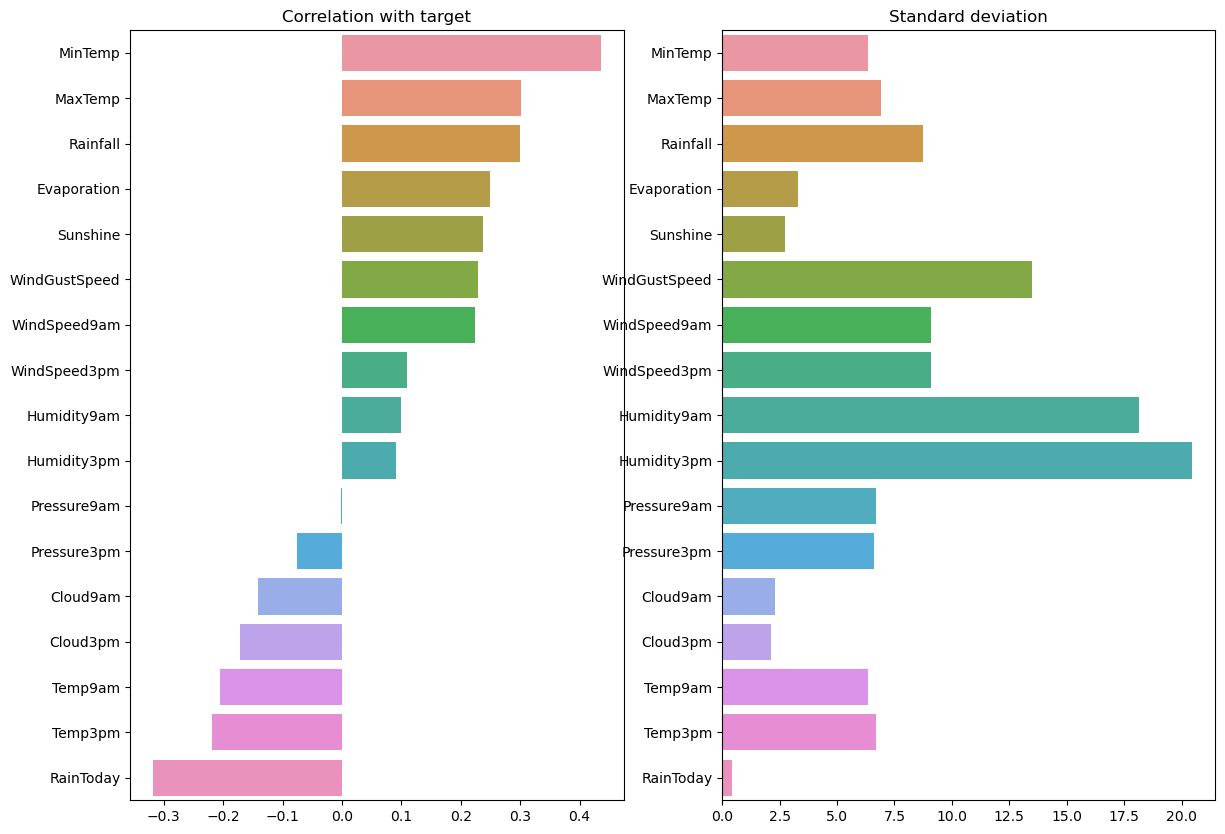

In [30]:
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlation = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)

fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
sns.barplot(y=numeric_features, x=correlation, ax=axs[0])
axs[0].set_title('Correlation with target')
sns.barplot(y=numeric_features, x=X_train[numeric_features].std(), ax=axs[1])
axs[1].set_title('Standard deviation')
plt.show()

Обработаем категориальные данные

In [31]:
categorical_features = categorical_data.columns
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

In [32]:
X[categorical_features].nunique()

WindGustDir    16
WindDir9am     16
WindDir3pm     16
dtype: int64

Pipeline

In [33]:
def makePipelineForStandardData(model):
    column_transformer = ColumnTransformer(transformers=[
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

Sklearn

In [34]:
logreg_pipeline = makePipelineForStandardData(LogisticRegression(solver='liblinear'))
logreg_model = logreg_pipeline.fit(X_train, y_train)

logreg_y_train_pred = logreg_model.predict(X_train)
logreg_y_pred = logreg_model.predict(X_test)

logreg_standard_train_score = roc_auc_score(y_train, logreg_y_train_pred)
logreg_standard_test_score = roc_auc_score(y_test, logreg_y_pred)
print("Train ROCAUC score: %.4f" % logreg_standard_test_score)
print("Test ROCAUC score: %.4f" % logreg_standard_test_score)

logreg_standard_score = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % logreg_standard_score)

Train ROCAUC score: 0.7119
Test ROCAUC score: 0.7119
Mean CV ROCAUC: 0.8547


Гиперпараметры

In [35]:
logreg_grid_params = {
    'model__C' : np.logspace(-3, 3, 10),
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [20, 50, 100]
}

In [36]:
logreg_grid_pipeline = makePipelineForStandardData(LogisticRegression(solver='liblinear'))
logreg_grid = GridSearchCV(logreg_grid_pipeline, logreg_grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
logreg_grid.fit(X_train, y_train)

logreg_best_penalty = logreg_grid.best_params_['model__penalty']
logreg_best_C = logreg_grid.best_params_['model__C']
logreg_best_max_iter = logreg_grid.best_params_['model__max_iter']
logreg_best_score = logreg_grid.best_score_

print("Best LogReg penalty params: ", logreg_best_penalty)
print("Best LogReg C params: %.4f" % logreg_best_C)
print("Best LogReg max_iter params: ", logreg_best_max_iter)
print("Best LogReg score: %.4f" % logreg_best_score)

Best LogReg penalty params:  l1
Best LogReg C params: 0.0215
Best LogReg max_iter params:  50
Best LogReg score: 0.8553


In [37]:
logreg_model = logreg_grid.best_estimator_
logreg_y_train_pred = logreg_model.predict(X_train)
logreg_y_pred = logreg_model.predict(X_test)

logreg_best_train_score = roc_auc_score(y_train, logreg_y_train_pred)
logreg_best_test_score = roc_auc_score(y_test, logreg_y_pred)
print("Train ROCAUC score: %.4f" % logreg_best_train_score)
print("Test ROCAUC score: %.4f" % logreg_best_test_score)

logreg_best_score = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % logreg_best_score)

Train ROCAUC score: 0.7163
Test ROCAUC score: 0.7087
Mean CV ROCAUC: 0.8553


In [38]:
logreg_results = pd.DataFrame({
    "Standard" : [logreg_standard_train_score, logreg_standard_test_score, logreg_standard_score],
    "Best" : [logreg_best_train_score, logreg_best_test_score, logreg_best_score]
}, index=["Logreg train score", "Logreg test score", "Logreg Mean CV score"])
logreg_results

,Standard,Best
Logreg train score,0.717661,0.716297
Logreg test score,0.711937,0.708721
Logreg Mean CV score,0.854744,0.855300


Как видно, применение гиперпараметров найденных с помощью GridSearchCV улучшает результат на кросс-валидации, но на отложенной выборке результат даже немного ухудшается

## KNN

In [39]:
knn_X_train = X_train.copy()
knn_X_test = X_test.copy()

In [40]:
knn_X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,5.339228,7.382788,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.65577,16.9,21.8,0.0
1,7.4,25.1,0.0,5.339228,7.382788,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.597829,4.65577,17.2,24.3,0.0
2,12.9,25.7,0.0,5.339228,7.382788,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.597829,2.00000,21.0,23.2,0.0
3,9.2,28.0,0.0,5.339228,7.382788,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.597829,4.65577,18.1,26.5,0.0
4,17.5,32.3,1.0,5.339228,7.382788,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0.0


Усредняем температуру

In [41]:
knn_X_train["Temp"] = (knn_X_train["Temp9am"] + knn_X_train["Temp3pm"]) / 2
knn_X_test["Temp"] = (knn_X_test["Temp9am"] + knn_X_test["Temp3pm"]) / 2
del knn_X_train["Temp9am"]
del knn_X_train["Temp3pm"]
del knn_X_test["Temp9am"]
del knn_X_test["Temp3pm"]

Влажность

In [42]:
knn_X_train["Humidity"] = (knn_X_train["Humidity9am"] + knn_X_train["Humidity3pm"]) / 2
knn_X_test["Humidity"] = (knn_X_test["Humidity9am"] + knn_X_test["Humidity3pm"]) / 2
del knn_X_train["Humidity9am"]
del knn_X_train["Humidity3pm"]
del knn_X_test["Humidity9am"]
del knn_X_test["Humidity3pm"]

Давление

In [43]:
knn_X_train["Pressure"] = (knn_X_train["Pressure9am"] + knn_X_train["Pressure3pm"]) / 2
knn_X_test["Pressure"] = (knn_X_test["Pressure9am"] + knn_X_test["Pressure3pm"]) / 2
del knn_X_train["Pressure9am"]
del knn_X_train["Pressure3pm"]
del knn_X_test["Pressure9am"]
del knn_X_test["Pressure3pm"]

Скорость ветра

In [44]:
knn_X_train["WindSpeed"] = (knn_X_train["WindSpeed9am"] + knn_X_train["WindSpeed3pm"]) / 2
knn_X_test["WindSpeed"] = (knn_X_test["WindSpeed9am"] + knn_X_test["WindSpeed3pm"]) / 2
del knn_X_train["WindSpeed9am"]
del knn_X_train["WindSpeed3pm"]
del knn_X_test["WindSpeed9am"]
del knn_X_test["WindSpeed3pm"]

Облачность

In [45]:
knn_X_train["Cloud"] = (knn_X_train["Cloud9am"] + knn_X_train["Cloud3pm"]) / 2
knn_X_test["Cloud"] = (knn_X_test["Cloud9am"] + knn_X_test["Cloud3pm"]) / 2
del knn_X_train["Cloud9am"]
del knn_X_train["Cloud3pm"]
del knn_X_test["Cloud9am"]
del knn_X_test["Cloud3pm"]

Удалим некоторые столбцы

In [46]:
del knn_X_train["WindGustDir"]
del knn_X_train["WindDir9am"]
del knn_X_train["WindDir3pm"]
del knn_X_test["WindGustDir"]
del knn_X_test["WindDir9am"]
del knn_X_test["WindDir3pm"]

In [47]:
knn_X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainToday,Temp,Humidity,Pressure,WindSpeed,Cloud
0,13.4,22.9,0.6,5.339228,7.382788,44.0,0.0,19.35,46.5,1007.40,22.0,6.327885
1,7.4,25.1,0.0,5.339228,7.382788,44.0,0.0,20.75,34.5,1009.20,13.0,4.626799
2,12.9,25.7,0.0,5.339228,7.382788,46.0,0.0,22.10,34.0,1008.15,22.5,3.298915
3,9.2,28.0,0.0,5.339228,7.382788,24.0,0.0,22.30,30.5,1015.20,10.0,4.626799
4,17.5,32.3,1.0,5.339228,7.382788,41.0,0.0,23.75,57.5,1008.40,13.5,7.500000


In [48]:
knn_numeric_features = knn_X_train.select_dtypes([np.number]).columns

def makePipelineForKNN(model):
    column_transformer = ColumnTransformer(transformers=[
        ('numeric', StandardScaler(), knn_numeric_features),
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

Модель

In [49]:
knn_pipeline = makePipelineForKNN(KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1))
knn_model = knn_pipeline.fit(knn_X_train, y_train)

knn_y_train_pred = knn_model.predict(knn_X_train)
knn_y_pred = knn_model.predict(knn_X_test)

knn_standard_train_score = roc_auc_score(y_train, knn_y_train_pred)
knn_standard_test_score = roc_auc_score(y_test, knn_y_pred)

print("Train cleared ROCAUC score: %.4f" % knn_standard_train_score)
print("Test cleared ROCAUC score: %.4f" % knn_standard_test_score)

knn_standard_score = cross_val_score(knn_model, knn_X_train, y_train, cv=5, scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % knn_standard_score)

Train cleared ROCAUC score: 0.7712
Test cleared ROCAUC score: 0.6798
Mean CV ROCAUC: 0.7821


ПОдбор k

In [50]:
def linear_weights(distance):
    k = distance.shape[1]
    return ((k - np.arange(0, k))/k) * np.ones_like(distance)

In [51]:
knn_grid_params = {
    'model__n_neighbors': [i for i in range(1, 15, 2)],
    'model__p': [1, 2, 3],
}

In [52]:
knn_grid_pipeline = makePipelineForKNN(KNeighborsClassifier(algorithm='kd_tree',
                                                                        weights=linear_weights,
                                                                        n_jobs=-1))
knn_grid = GridSearchCV(knn_grid_pipeline, knn_grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(knn_X_train, y_train)

knn_best_n_neighbors = knn_grid.best_params_['model__n_neighbors']
knn_best_p = knn_grid.best_params_['model__p']
knn_best_score = knn_grid.best_score_

print("Best KNN n_neighbors param: ", knn_best_n_neighbors)
print("Best KNN p param: ", knn_best_p)
print("Best KNN score: %.4f" % knn_best_score)

Best KNN n_neighbors param:  13
Best KNN p param:  3
Best KNN score: 0.8157


In [53]:
knn_pipeline = makePipelineForKNN(KNeighborsClassifier(algorithm='kd_tree',
                                                       n_neighbors=knn_best_n_neighbors,
                                                       p=knn_best_p,
                                                       weights=linear_weights,
                                                       n_jobs=-1))
knn_model = knn_pipeline.fit(knn_X_train, y_train)
knn_y_train_pred = knn_model.predict(knn_X_train)
knn_y_pred = knn_model.predict(knn_X_test)

knn_best_train_score = roc_auc_score(y_train, knn_y_train_pred)
knn_best_test_score = roc_auc_score(y_test, knn_y_pred)
print("Train ROCAUC score: %.4f" % knn_best_train_score)
print("Test ROCAUC score: %.4f" % knn_best_test_score)

knn_best_score = cross_val_score(knn_model, knn_X_train, y_train, cv=5, scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % knn_best_score)

Train ROCAUC score: 0.7566
Test ROCAUC score: 0.6808
Mean CV ROCAUC: 0.8157


In [54]:
knn_results = pd.DataFrame({
    "Standard" : [knn_standard_train_score, knn_standard_test_score, knn_standard_score],
    "Best" : [knn_best_train_score, knn_best_test_score, knn_best_score]
}, index=["KNN train score", "KNN test score", "KNN Mean CV score"])
knn_results

,Standard,Best
KNN train score,0.771219,0.756609
KNN test score,0.679755,0.680791
KNN Mean CV score,0.782061,0.815674


Видно, что подбор гиперпараметров дал прирост в качестве, но логистическая регрессия все равно показывает лучший результат

Наивный Байес

In [55]:
def makePipelineForNB(model):
    column_transformer = ColumnTransformer(transformers=[
        ('numeric', MinMaxScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    return Pipeline(steps=[
        ('column_transformer', column_transformer),
        ('model', model)
    ])

In [56]:
multinomial_nb_pipeline = makePipelineForNB(MultinomialNB())
multinomial_nb_model = multinomial_nb_pipeline.fit(X_train, y_train)

multinomial_nb_y_train_pred = multinomial_nb_model.predict(X_train)
multinomial_nb_y_pred = multinomial_nb_model.predict(X_test)

multinomial_nb_train_score = roc_auc_score(y_train, multinomial_nb_y_train_pred)
multinomial_nb_test_score = roc_auc_score(y_test, multinomial_nb_y_pred)

print("Train raw ROCAUC score: %.4f" % multinomial_nb_train_score)
print("Test raw ROCAUC score: %.4f" % multinomial_nb_test_score)

multinomial_nb_score = cross_val_score(multinomial_nb_model, X_train, y_train, cv=5,
                                             scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % multinomial_nb_score)

Train raw ROCAUC score: 0.5451
Test raw ROCAUC score: 0.5628
Mean CV ROCAUC: 0.7295


In [57]:
bernoulli_nb_pipeline = makePipelineForNB(BernoulliNB())
bernoulli_nb_model = bernoulli_nb_pipeline.fit(X_train, y_train)

bernoulli_nb_y_train_pred = bernoulli_nb_model.predict(X_train)
bernoulli_nb_y_pred = bernoulli_nb_model.predict(X_test)

bernoulli_nb_train_score = roc_auc_score(y_train, bernoulli_nb_y_train_pred)
bernoulli_nb_test_score = roc_auc_score(y_test, bernoulli_nb_y_pred)

print("Train ROCAUC score: %.4f" % bernoulli_nb_train_score)
print("Test ROCAUC score: %.4f" % bernoulli_nb_test_score)

bernoulli_nb_score = cross_val_score(bernoulli_nb_model, X_train, y_train, cv=5,
                                             scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % bernoulli_nb_score)

Train ROCAUC score: 0.6540
Test ROCAUC score: 0.6785
Mean CV ROCAUC: 0.7153


In [58]:
complement_nb_pipeline = makePipelineForNB(ComplementNB())
complement_nb_model = complement_nb_pipeline.fit(X_train, y_train)

complement_nb_y_train_pred = complement_nb_model.predict(X_train)
complement_nb_y_pred = complement_nb_model.predict(X_test)

complement_nb_train_score = roc_auc_score(y_train, complement_nb_y_train_pred)
complement_nb_test_score = roc_auc_score(y_test, complement_nb_y_pred)

print("Train ROCAUC score: %.4f" % complement_nb_train_score)
print("Test ROCAUC score: %.4f" % complement_nb_test_score)

complement_nb_score = cross_val_score(complement_nb_model, X_train, y_train, cv=5,
                                             scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % complement_nb_score)

Train ROCAUC score: 0.6926
Test ROCAUC score: 0.7335
Mean CV ROCAUC: 0.7295


Как мы видим лучший результат дает ComplementNV, будем использовать его

Подбор гиперпараметров

In [59]:
nb_grid_params = {
    'model__alpha' : np.logspace(0, 3, 100),
}

In [60]:
nb_grid_pipeline = makePipelineForNB(ComplementNB())
nb_grid = GridSearchCV(nb_grid_pipeline, nb_grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
nb_grid.fit(X_train, y_train)

nb_best_alpha = nb_grid.best_params_['model__alpha']
nb_best_score = nb_grid.best_score_

print("Best Naive Bayes alpha param: ", nb_best_alpha)
print("Best Naive Bayes score: %.4f" % nb_best_score)

Best Naive Bayes alpha param:  464.1588833612782
Best Naive Bayes score: 0.7334


In [61]:
nb_model = nb_grid.best_estimator_
nb_y_train_pred = nb_model.predict(X_train)
nb_y_pred = nb_model.predict(X_test)

nb_best_train_score = roc_auc_score(y_train, nb_y_train_pred)
nb_best_test_score = roc_auc_score(y_test, nb_y_pred)
print("Train ROCAUC score: %.4f" % nb_best_train_score)
print("Test ROCAUC score: %.4f" % nb_best_test_score)

nb_best_score = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='roc_auc').mean()
print("Mean CV ROCAUC: %.4f" % nb_best_score)

Train ROCAUC score: 0.6898
Test ROCAUC score: 0.7289
Mean CV ROCAUC: 0.7334


In [62]:
nb_results = pd.DataFrame({
    "Standard" : [complement_nb_train_score, complement_nb_test_score, complement_nb_score],
    "Best" : [nb_best_train_score, nb_best_test_score, nb_best_score]
}, index=["Naive Bayes train score", "Naive Bayes test score", "Naive Bayes Mean CV score"])
nb_results

,Standard,Best
Naive Bayes train score,0.692561,0.689834
Naive Bayes test score,0.733525,0.728946
Naive Bayes Mean CV score,0.729533,0.733434


Наивный Байес показывает лучший результат на отложенной выборке, но худший на кросс-валидации

Самостоятельная реализация

In [63]:
my_X_train = X_train.copy()
my_X_test = X_test.copy()

In [64]:
def ohe_transform(X, features):
    ohe = OneHotEncoder()
    new_features = []
    for feature in features:
        new_ohe_feature = ohe.fit_transform(X[[feature]])
        new_features.append(new_ohe_feature.toarray())
    encoded_X = np.hstack((new_features[0], new_features[1]))
    for i in range(2, len(new_features)):
        encoded_X = np.hstack((encoded_X, new_features[i]))
    return encoded_X

def std_scaler_transform(X, features):
    return StandardScaler().fit_transform(X[features])

In [65]:
my_X_train = np.hstack((ohe_transform(my_X_train, categorical_features), std_scaler_transform(my_X_train, numeric_features)))
my_X_test = np.hstack((ohe_transform(my_X_test, categorical_features), std_scaler_transform(my_X_test, numeric_features)))

In [66]:
my_y_train = y_train.values
my_y_test = y_test.values

Построение модели

In [67]:
my_optimal_theta = fit(my_X_train, my_y_train, plot=False)

my_y_train_pred = binary_class_prediction(my_optimal_theta, my_X_train)
my_y_pred = binary_class_prediction(my_optimal_theta, my_X_test)

my_standard_train_score = roc_auc_score(my_y_train, my_y_train_pred)
my_standard_test_score = roc_auc_score(my_y_test, my_y_pred)

print("Train ROCAUC score: %.4f" % my_standard_train_score)
print("Test ROCAUC score: %.4f" % my_standard_test_score)

Train ROCAUC score: 0.6007
Test ROCAUC score: 0.5793


Гиперпараметры

In [68]:
batch_sizes = [10 + i * 5 for i in range(11)]
hs = [0.001, 0.01, 0.02, 0.05, 0.1]

In [69]:
max_score = 0
best_params = {"batch": -1, "h": -1, "iters": -1}
best_theta = np.array([])
for batch in batch_sizes:
    for h in hs:
        optimal_theta = fit(my_X_train, my_y_train, plot=False, batch_size=batch, h=h)
        pred = binary_class_prediction(my_optimal_theta, my_X_train)
        score = roc_auc_score(my_y_train, pred)
        if max_score < score:
            max_score = score
            best_params["batch"] = batch
            best_params["h"] = h
            best_theta = optimal_theta

In [70]:
my_best_optimal_theta = best_theta

my_best_y_train_pred = binary_class_prediction(my_best_optimal_theta, my_X_train)
my_best_y_pred = binary_class_prediction(my_best_optimal_theta, my_X_test)

my_best_train_score = roc_auc_score(my_y_train, my_best_y_train_pred)
my_best_test_score = roc_auc_score(my_y_test, my_best_y_pred)

print("Train ROCAUC score: %.4f" % my_best_train_score)
print("Test ROCAUC score: %.4f" % my_best_test_score)

Train ROCAUC score: 0.5657
Test ROCAUC score: 0.5510


In [71]:
my_results = pd.DataFrame({
    "Standard" : [my_standard_train_score, my_standard_test_score],
    "Best" : [my_best_train_score, my_best_test_score]
}, index=["My train score", "My test score"])
my_results

,Standard,Best
My train score,0.600727,0.565653
My test score,0.579340,0.551007


## Общий вывод


In [72]:
all_results = pd.concat([logreg_results, knn_results, nb_results, my_results])
all_results

,Standard,Best
Logreg train score,0.717661,0.716297
Logreg test score,0.711937,0.708721
Logreg Mean CV score,0.854744,0.855300
KNN train score,0.771219,0.756609
KNN test score,0.679755,0.680791
KNN Mean CV score,0.782061,0.815674
Naive Bayes train score,0.692561,0.689834
Naive Bayes test score,0.733525,0.728946
Naive Bayes Mean CV score,0.729533,0.733434
My train score,0.600727,0.565653


Как видно:

на кросс-валидации лучшее качество у KNN с подобранными гиперпараметрами,
на отложенной выборке у Наивного Байесовского классификатора со стандартными параметрами, это объясняется тем, что гиперпараметры были подобраны с помощью GrisSearchCV, а он выдает параметры для улучшения качаства на кросс-валидации